### Import packages

In [1]:
#Import packages for section 2
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from numpy import linalg as LA
import time

#Import packages for section 3
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Gradient descent for ridge(less) linear regression

### Feature normalization

In [4]:
def feature_normalization(train, test):
    """Rescale the data so that each feature in the training set is in
    the interval [0,1], and apply the same transformations to the test
    set, using the statistics computed on the training set.

    Args:
        train - training set, a 2D numpy array of size(num_instances, num_features)
        test - test set, a 2D numpy array of size(num_instances, num_features)

    Returns:
        train_normalized - training set after normalization
        test_normalized - test set after normalization
    """
    
    #Normalize training set
    train_min = np.min(train)
    train_max = np.max(train)
    train_normalized = (train - train_min) / (train_max - train_min)
    
    #Normalize test set
    test_min = np.min(test)
    test_max = np.max(test)
    test_normalized = (test - test_min) / (test_max - test_min)
    
    return train_normalized, test_normalized

In [5]:
def load_data():
    print('loading the dataset')
    df = pd.read_csv('ridge_regression_dataset.csv', delimiter=',')
    X = df.values[:,:-1]
    y = df.values[:,-1]

    print('Split into Train and Test')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100, random_state=10)

    print("Scaling all to [0, 1]")
    X_train, X_test = feature_normalization(X_train, X_test)
    X_train = np.hstack((X_train, np.ones((X_train.shape[0], 1))))  # Add bias term
    X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1))))
    return X_train, y_train, X_test, y_test

In [7]:
#Call function to find test/training sets for X and y
X_train, y_train, X_test, y_test = load_data()

#Set variables for instances and features
num_instances = X_train.shape[0]
num_features = X_train.shape[1]

loading the dataset
Split into Train and Test
Scaling all to [0, 1]


# Linear regression

In [9]:
def compute_square_loss(X, y, theta):
    """
    Given a set of X, y, theta, compute the average square loss for predicting y with X*theta.

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        theta - the parameter vector, 1D array of size(num_features)

    Returns:
        loss - the average square loss, scalar
    """
    hypothesis = X @ theta
    n = len(X)
    loss = hypothesis - y
    sq_loss = (1 / n) * LA.norm(loss)**2
    return sq_loss

In [10]:
def compute_square_loss_gradient(X, y, theta):
    """
    Compute the gradient of the average square loss(as defined in compute_square_loss), at the point theta.

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        theta - the parameter vector, 1D numpy array of size(num_features)

    Returns:
        grad - gradient vector, 1D numpy array of size(num_features)
    """
    hypothesis = X @ theta
    n = len(X)
    loss = hypothesis - y
    gradient = (2 / n) * X.T @ loss
    return gradient

In [13]:
theta_rand = np.random.rand(num_features)
compute_square_loss_gradient(X_train, y_train, theta_rand)

array([15.3141337 , 15.1232969 , 14.9660088 , 14.89079425, 14.79361145,
       14.71905272, 14.59502266, 14.59502266, 14.47349224, 14.27723498,
       14.11799764, 14.04515197, 13.84182509, 13.69961264, 13.34334664,
       13.27734375, 13.14898287, 12.90708688, 14.76811443, 14.76811443,
       22.40011605, 14.57603966, 14.57603966, 21.43974223, 14.34876642,
       14.34876642, 20.30337601, 14.1555629 , 14.1555629 , 19.3373584 ,
       13.99960602, 13.99960602, 18.55757401, 11.11316923, 11.11316923,
        4.12539007, 11.31478444, 11.31478444,  5.13346611, 11.52746461,
       11.52746461,  6.19686696, 11.70374782, 11.70374782,  7.07828301,
       11.84459916, 11.84459916,  7.78253971, 25.7201441 ])

# Gradient checker

In [14]:
def grad_checker(X, y, theta, epsilon=0.01, tolerance=1e-4):
    """Implement Gradient Checker
    Check that the function compute_square_loss_gradient returns the
    correct gradient for the given X, y, and theta.

    Let d be the number of features. Here we numerically estimate the
    gradient by approximating the directional derivative in each of
    the d coordinate directions:
(e_1 =(1,0,0,...,0), e_2 =(0,1,0,...,0), ..., e_d =(0,...,0,1))

    The approximation for the directional derivative of J at the point
    theta in the direction e_i is given by:
(J(theta + epsilon * e_i) - J(theta - epsilon * e_i)) /(2*epsilon).

    We then look at the Euclidean distance between the gradient
    computed using this approximation and the gradient computed by
    compute_square_loss_gradient(X, y, theta).  If the Euclidean
    distance exceeds tolerance, we say the gradient is incorrect.

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        theta - the parameter vector, 1D numpy array of size(num_features)
        epsilon - the epsilon used in approximation
        tolerance - the tolerance error

    Return:
        A boolean value indicating whether the gradient is correct or not
    """
    true_gradient = compute_square_loss_gradient(X, y, theta) #The true gradient
    num_features = theta.shape[0]
    approx_grad = np.zeros(num_features) #Initialize the gradient we approximate
    
    #Loop through each feature
    for position in range(num_features):
        
        #Create vector for each e_i
        e_i = np.zeros(num_features)
        e_i[position] = 1
        
        #Update theta plus and minus
        theta_plus = theta + epsilon * e_i
        theta_minus = theta - epsilon * e_i
        
        #Calculate approximate gradient and distance
        approx_grad[position] = (compute_square_loss(X, y, theta_plus) - compute_square_loss(X, y, theta_minus)) / (2 * epsilon)
        distance = np.linalg.norm(approx_grad - true_gradient)
        
        #Determine if distance is within tolerance
        result = (distance < tolerance)
        
    return result

In [15]:
grad_checker(X_train, y_train, theta_rand, epsilon=0.01, tolerance=1e-4)

True

### Batch gradient descent

In [16]:
def batch_grad_descent(X, y, alpha=0.05, num_step=1000, grad_check=False):
    """
    In this question you will implement batch gradient descent to
    minimize the average square loss objective.

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        alpha - step size in gradient descent
        num_step - number of steps to run
        grad_check - a boolean value indicating whether checking the gradient when updating

    Returns:
        theta_hist - the history of parameter v
        ector, 2D numpy array of size(num_step+1, num_features)
                     for instance, theta in step 0 should be theta_hist[0], theta in step(num_step) is theta_hist[-1]
        loss_hist - the history of average square loss on the data, 1D numpy array,(num_step+1)
    """
    num_instances, num_features = X.shape[0], X.shape[1]
    theta_hist = np.zeros((num_step + 1, num_features))  #Initialize theta_hist
    loss_hist = np.zeros(num_step + 1)  #Initialize loss_hist
    theta = np.ones(num_features)  #Initialize theta
    
    #Calculate initial loss
    for i in range(num_step+1):
        
        #Record initial loss and theta values
        if i == 0:
            loss_hist[i] = compute_square_loss(X, y, theta)
            theta_hist[i,:] = theta
        
        #Calculate gradient        
        gradient_i = compute_square_loss_gradient(X, y, theta)
        
        #Use grad_checker to determine if distance exceeds tolerance
        if grad_check:
            if grad_checker(X, y, theta) == False:
                print(f"Alpha: {alpha}")
                print(f"Gradient fail at step: {i}")
                break
                
        #Update theta, add to theta history
        theta = theta - alpha * gradient_i
        theta_hist[i,:] = theta

        #Update loss, add to loss history
        J_i = compute_square_loss(X, y, theta)
        loss_hist[i] = J_i
    
    return theta_hist, loss_hist

In [17]:
batch_grad_descent(X_train, y_train, alpha=0.1, num_step=1000, grad_check=False)

(array([[-2.12716592e+000, -2.09188355e+000, -2.06199132e+000, ...,
         -1.42113082e+000, -6.04381183e-001, -4.25061933e+000],
        [ 4.18135717e+000,  4.15638148e+000,  4.13238582e+000, ...,
          3.46898392e+000,  2.67112119e+000,  6.33688179e+000],
        [-8.59124353e+000, -8.48335199e+000, -8.39187347e+000, ...,
         -6.42604216e+000, -3.92245472e+000, -1.51038255e+001],
        ...,
        [-3.51508870e+305, -3.47950676e+305, -3.44830356e+305, ...,
         -2.72368311e+305, -1.81801281e+305, -5.90018213e+305],
        [ 7.10843438e+305,  7.03647832e+305,  6.97337725e+305, ...,
          5.50800402e+305,  3.67650033e+305,  1.19317209e+306],
        [-1.43751250e+306, -1.42296109e+306, -1.41020039e+306, ...,
         -1.11386336e+306, -7.43485117e+305, -2.41290797e+306]]),
 array([ 2836.34301559, 11575.68510538, 47315.69228514, ...,
                   inf,            inf,            inf]))

Highest value of alpha that still converges: 0.066


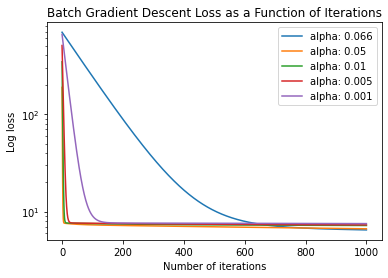

In [19]:
#Experimentation with step sizes
alpha_list = [0.066, 0.05, 0.01, 0.005, 0.001]
x = np.linspace(0, 1000, 1001)

#Loop through each alpha value and plot
for alpha_i in alpha_list:
    theta_hist, loss_hist = batch_grad_descent(X_train, y_train, alpha = alpha_i, grad_check=True)
    plt.plot(x, loss_hist, label = 'alpha: ' + str(alpha_i))
plt.yscale('log')
plt.xlabel('Number of iterations')
plt.ylabel('Log loss')
plt.title('Batch Gradient Descent Loss as a Function of Iterations')
plt.legend()

#Print best result
print(f"Highest value of alpha that still converges: {0.066}")

Summary of findings: 
The highest value of alpha that still converges is 0.066. This value of alpha takes significantly more iterations to converge.

In [21]:
#Set alpha to the learning rate from selected from q12
alpha = 0.066
iterations = 100000
test_loss_history = []
num_features = X_train.shape[1]
theta = np.zeros(num_features)

#Calculate test loss
for i in range(iterations):
    gradient = compute_square_loss_gradient(X_train, y_train, theta)
    theta = theta - alpha * gradient.T
    test_loss_i = compute_square_loss(X_test, y_test, theta)
    test_loss_history.append(test_loss_i)

Overfitting: test error decreases until ~15,000 iterations, then increases.


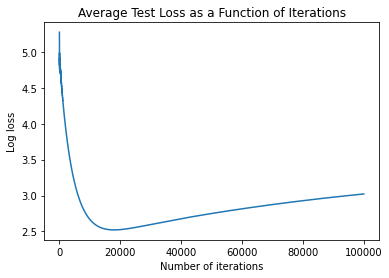

In [22]:
#Plot results
plt.plot(range(iterations), test_loss_history)
plt.xlabel('Number of iterations')
plt.ylabel('Log loss')
plt.title('Average Test Loss as a Function of Iterations')
print('Overfitting: test error decreases until ~15,000 iterations, then increases.')

### Ridge Regression

In [23]:
def compute_regularized_square_loss_gradient(X, y, theta, lambda_reg):
    """
    Compute the gradient of L2-regularized average square loss function given X, y and theta

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        theta - the parameter vector, 1D numpy array of size(num_features)
        lambda_reg - the regularization coefficient

    Returns:
        grad - gradient vector, 1D numpy array of size(num_features)
    """
    #Use previously defined function for square loss gradient from q9
    sq_loss_gradient = compute_square_loss_gradient(X, y, theta)
    
    #Use formula for regularized gradient from q14
    reg_gradient = 2 * lambda_reg * theta
    
    #Sum values to calculate the regularized square loss gradient
    reg_sq_loss_gradient = sq_loss_gradient + reg_gradient
    return reg_sq_loss_gradient

In [24]:
def regularized_grad_descent(X, y, alpha=0.05, lambda_reg=10**-2, num_step=1000):
    """
    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        alpha - step size in gradient descent
        lambda_reg - the regularization coefficient
        num_step - number of steps to run
    
    Returns:
        theta_hist - the history of parameter vector, 2D numpy array of size(num_step+1, num_features)
                     for instance, theta in step 0 should be theta_hist[0], theta in step(num_step+1) is theta_hist[-1]
        loss hist - the history of average square loss function without the regularization term, 1D numpy array.
    """
    num_instances, num_features = X.shape[0], X.shape[1]
    theta = np.ones(num_features) #Initialize theta
    theta_hist = np.zeros((num_step+1, num_features)) #Initialize theta_hist
    loss_hist = np.zeros(num_step+1) #Initialize loss_hist
    
    #Loop through iterations
    for i in range(num_step + 1):
        
        #Calculate initial loss and theta
        if i == 0:
            loss_hist[i] = compute_square_loss(X, y, theta)
            theta_hist[i] = theta
            
        #Calculate gradient using function from q15, use to update theta
        grad = compute_regularized_square_loss_gradient(X, y, theta, lambda_reg)
        theta = theta - alpha * grad.T
        
        #Record loss and theta
        loss_hist[i] = compute_square_loss(X, y, theta)
        theta_hist[i,] = theta
        
    return loss_hist, theta_hist

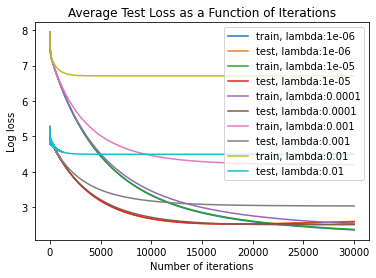

In [25]:
#Set iterations, number of features, lambda values, and theta
iterations = 30000
num_features = X_train.shape[1]
lambda_list = [10e-7, 10e-6, 10e-5, 10e-4, 10e-3]
theta = np.zeros(num_features)

#Loop through lambda values
for lambda_i in lambda_list:
    theta = np.zeros(num_features)
    train_loss_history = []
    test_loss_history = []

    #Loop through iterations to record train and test loss
    for i in range(iterations):
        gradient = compute_regularized_square_loss_gradient(X_train, y_train, theta, lambda_reg = lambda_i)
        theta = theta - alpha * gradient.T
        train_loss_i = compute_square_loss(X_train, y_train, theta)
        train_loss_history.append(train_loss_i)
        test_loss_i = compute_square_loss(X_test, y_test, theta)
        test_loss_history.append(test_loss_i)

    #Plot results
    plt.plot(range(iterations), train_loss_history, label = 'train, lambda:' + str(lambda_i))
    plt.plot(range(iterations), test_loss_history, label = 'test, lambda:' + str(lambda_i))

#Label plot
plt.xlabel('Number of iterations')
plt.ylabel('Log loss')
plt.title('Average Test Loss as a Function of Iterations')
plt.legend()

In terms of overfitting, the test loss for lambda = 1e-5 appears to reach its minimum the earliest. After reaching it's minimum loss, the loss begins to rise again, demonstrating overfitting (increasing test loss).

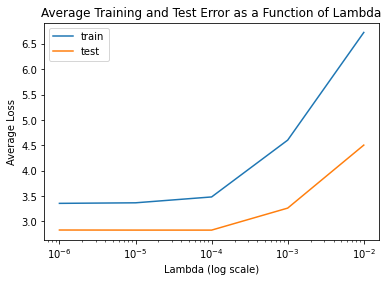

In [26]:
#Initialize lists for average train and test loss
train_loss_avg = []
test_loss_avg = []

#Loop through lambda values
for lambda_i in lambda_list:
    theta = np.zeros(num_features)
    train_loss_history = []
    test_loss_history = []

    #Loop through iterations to record train and test loss
    for i in range(iterations):
        gradient = compute_regularized_square_loss_gradient(X_train, y_train, theta, lambda_reg = lambda_i)
        theta = theta - alpha * gradient.T
        train_loss_i = compute_square_loss(X_train, y_train, theta)
        train_loss_history.append(train_loss_i)
        test_loss_i = compute_square_loss(X_test, y_test, theta)
        test_loss_history.append(test_loss_i)
    
    #Add to average train and test loss lists
    train_loss_avg.append(np.mean(train_loss_history))
    test_loss_avg.append(np.mean(test_loss_history))
        
#Plot results
plt.plot(lambda_list, train_loss_avg, label = 'train')
plt.plot(lambda_list, test_loss_avg, label = 'test')
plt.xscale('log')
plt.xlabel('Lambda (log scale)')
plt.ylabel('Average Loss')
plt.title('Average Training and Test Error as a Function of Lambda')
plt.legend()

I would choose a lambda value of 10^-4, as that value minimizes the test loss.

Minimum test loss: 2.825188937721973
Lambda resulting in minimum test loss: 0.0001
This value of lambda (from early stopping) is the same as the selected value of lambda from before.


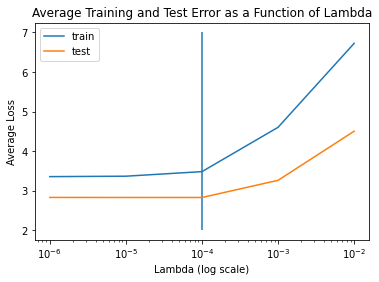

In [27]:
#Plot results
plt.plot(lambda_list, train_loss_avg, label = 'train')
plt.plot(lambda_list, test_loss_avg, label = 'test')
plt.xscale('log')
plt.xlabel('Lambda (log scale)')
plt.ylabel('Average Loss')
plt.title('Average Training and Test Error as a Function of Lambda')
plt.vlines(x = lambda_list[2], ymin = 2, ymax = 7)
plt.legend()

print(f'Minimum test loss: {min(test_loss_avg)}')
print(f'Lambda resulting in minimum test loss: {lambda_list[2]}')
print('This value of lambda (from early stopping) is the same as the selected value of lambda from before.')

In [28]:
#Set iterations, number of features, lambda values, and theta
iterations = 100000
num_features = X_train.shape[1]
lambda_list = [10e-7, 10e-6, 10e-5]
theta = np.zeros(num_features)
min_loss_list = []
min_loss_index = []
best_theta = []
theta_hist = []

#Loop through lambda values
for lambda_i in lambda_list:
    theta = np.zeros(num_features)
    test_loss_history = []
    min_loss = 3

    #Loop through iterations to record train and test loss
    for i in range(iterations):
        gradient = compute_regularized_square_loss_gradient(X_train, y_train, theta, lambda_reg = lambda_i)
        theta = theta - alpha * gradient.T
        theta_hist.append(theta)
        test_loss_i = compute_square_loss(X_test, y_test, theta)
        test_loss_history.append(test_loss_i)
        
    test_loss_min = min(test_loss_history)
    test_loss_min_index = test_loss_history.index(test_loss_min)
    best_theta.append(theta_hist[test_loss_min_index])
    
    print(f'Lambda: {lambda_i}')
    print(f'Test loss: {test_loss_min}')
    print(f'Index for minimum test loss: {test_loss_min_index}', '\n')
    
print(f'Best choice for theta: {best_theta[2]}')

Lambda: 1e-06
Test loss: 2.520949956628234
Index for minimum test loss: 17997 

Lambda: 1e-05
Test loss: 2.519387713094107
Index for minimum test loss: 18411 

Lambda: 0.0001
Test loss: 2.501500287700501
Index for minimum test loss: 25353 

Best choice for theta: [-1.04846397e+01  5.02998338e+00  1.48486259e+01  2.36414394e+01
 -2.00947430e+01 -1.10316747e+01 -1.03603464e+01 -1.03603464e+01
  6.47305163e+00  1.44205975e+01  2.43851807e+01 -5.62311588e+00
 -1.79730063e+01 -4.45713206e+01  1.43192053e+01  2.36667050e+01
  1.28926264e+01  2.12176583e+00 -1.06784886e+00 -1.06784886e+00
 -6.57235472e-01 -8.37611950e-01 -8.37611950e-01  4.93949103e-01
 -7.50301509e-01 -7.50301509e-01  9.30501307e-01 -7.35879908e-01
 -7.35879908e-01  1.00260931e+00 -7.49735765e-01 -7.49735765e-01
  9.33330026e-01 -9.37591997e-01 -9.37591997e-01 -5.95113384e-03
 -5.92819487e-01 -5.92819487e-01  1.71791142e+00 -5.10691452e-01
 -5.10691452e-01  2.12855159e+00 -5.19428918e-01 -5.19428918e-01
  2.08486426e+00 -5.5

In practice, I would select the value of theta above. This value is best because it uses the value of lambda that minimizes test loss (lambda = 1e-4). Within the possible values of theta for that given lambda, this value leads to the lowest test loss. Because of this, we can expect the value of theta below to generalize to unseen data the best, based on having the lowest test loss.

# Stochastic Gradient Descent (SGD)

In [29]:
def stochastic_grad_descent(X, y, alpha=0.01, lambda_reg=10**-2, num_epoch=1000, eta0=False):
    """
    In this question you will implement stochastic gradient descent with regularization term

    Args:
        X - the feature vector, 2D numpy array of size(num_instances, num_features)
        y - the label vector, 1D numpy array of size(num_instances)
        alpha - string or float, step size in gradient descent
                NOTE: In SGD, it's not a good idea to use a fixed step size. Usually it's set to 1/sqrt(t) or 1/t
                if alpha is a float, then the step size in every step is the float.
                if alpha == "1/sqrt(t)", alpha = 1/sqrt(t).
                if alpha == "1/t", alpha = 1/t.
        lambda_reg - the regularization coefficient
        num_epoch - number of epochs to go through the whole training set

    Returns:
        theta_hist - the history of parameter vector, 3D numpy array of size(num_epoch, num_instances, num_features)
                     for instance, theta in epoch 0 should be theta_hist[0], theta in epoch(num_epoch) is theta_hist[-1]
        loss hist - the history of loss function vector, 2D numpy array of size(num_epoch, num_instances)
    """
    num_instances, num_features = X.shape[0], X.shape[1]
    theta = np.ones(num_features) #Initialize theta
   
    theta_hist = np.zeros((num_epoch + 1, num_features))
    loss_hist = np.zeros((num_epoch + 1))

    #Loop through each epoch
    for i in range(num_epoch + 1):
        
        #Record initial values for loss and theta
        if i == 0:
            loss_hist[i] = compute_square_loss(X, y, theta)
            theta_hist[i,] = theta
            
        #Adjust step size according to inputted alpha value
        if alpha == '1/sqrt(t)':
            step_size = 1.0 / np.sqrt(i + 1.0)
        elif alpha == '1/t':
            step_size = 1.0 / (i + 1.0)
        else:
            step_size = alpha
            
        #Train/test/split, normalize
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 52)
        X_train, X_test = feature_normalization(X_train, X_test)
        
        #Calculate gradient, update theta for training data
        gradient = compute_regularized_square_loss_gradient (X_train, y_train, theta, lambda_reg)
        theta = theta - step_size * gradient.T
        
        #Calculate gradient, update theta for test data
        gradient = compute_regularized_square_loss_gradient (X_test, y_test, theta, lambda_reg)
        theta = theta - step_size * gradient.T
        
        #Calculate loss, record loss and theta
        loss_i = compute_square_loss(X, y, theta) + np.dot(theta, theta) * lambda_reg
        loss_hist[i] = loss_i
        theta_hist[i,] = theta
        
    return loss_hist, theta_hist

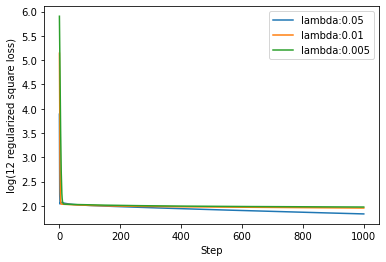

In [30]:
#Set list of step sizes
step_size_list = [0.05, 0.01, 0.005]

#Loop through each step size to calculate loss history
for step_size_i in step_size_list:
    loss_hist_SGD, theta_hist_SGD = stochastic_grad_descent(X_train, y_train, lambda_reg = 1e-5,alpha = step_size_i)
    
    #Plot results
    plt.plot(range(len(loss_hist_SGD)), np.log(loss_hist_SGD), label = 'lambda:' + str(step_size_i))
plt.xlabel("Step")
plt.ylabel("log(12 regularized square loss)")
plt.legend()
plt.show()

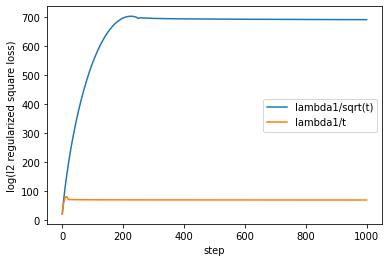

In [31]:
#Set list of step size functions
step_size_functions = ['1/sqrt(t)', '1/t']

#Loop through each step size function
for function_i in step_size_functions:
    loss_hist_SGD, theta_hist_SGD = stochastic_grad_descent(X_train, y_train, lambda_reg = 1e-5, alpha = function_i)
    
    #Plot results
    plt.plot(range(len(loss_hist_SGD)), np.log(loss_hist_SGD), label = 'lambda' + str(function_i))
plt.xlabel('step')
plt.ylabel('log(l2 regularized square loss)')
plt.legend()
plt.show()

/var/folders/sh/841byyw54k523rbq64rc4qbr0000gn/T/ipykernel_51677/3494319606.py:16: RuntimeWarning: overflow encountered in matmul
  gradient = (2 / n) * X.T @ loss
/var/folders/sh/841byyw54k523rbq64rc4qbr0000gn/T/ipykernel_51677/3494319606.py:16: RuntimeWarning: invalid value encountered in matmul
  gradient = (2 / n) * X.T @ loss
/var/folders/sh/841byyw54k523rbq64rc4qbr0000gn/T/ipykernel_51677/2494859403.py:53: RuntimeWarning: invalid value encountered in subtract
  theta = theta - step_size * gradient.T
/var/folders/sh/841byyw54k523rbq64rc4qbr0000gn/T/ipykernel_51677/3494319606.py:13: RuntimeWarning: invalid value encountered in matmul
  hypothesis = X @ theta


SGD runtime for 1000 steps: 0.00042773914337158203
RGD runtime for 1000 steps: 2.6968002319335936e-05


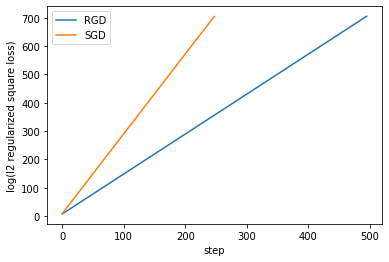

In [27]:
#Estimate time to run a single epoch for SGD
start_time = time.time()
SGD_loss, SGD_theta = stochastic_grad_descent(X_train, y_train, lambda_reg = 1e-5, alpha = 0.1)
SGD_runtime = time.time() - start_time
print(f'SGD runtime for 1000 steps: {SGD_runtime / 1000}')

#Compare to regularized gradient descent
start_time = time.time()
RGD_loss, RGD_theta = regularized_grad_descent(X_train, y_train, lambda_reg = 1e-5, alpha = 0.1)
RGD_runtime = time.time() - start_time
print(f'RGD runtime for 1000 steps: {RGD_runtime / 1000}')

#Plot comparison between SGD and RGD
plt.plot(range(len(RGD_loss)), np.log(RGD_loss), label = 'RGD')
plt.plot(range(len(SGD_loss)), np.log(SGD_loss), label = 'SGD')
plt.xlabel('step')
plt.ylabel('log(l2 regularized square loss)')
plt.legend()
plt.show()

# Logistic regression

In [32]:
def pre_process_mnist_01():
    """
    Load the mnist datasets, selects the classes 0 and 1 
    and normalize the data.
    Args: none
    Outputs: 
        X_train: np.array of size (n_training_samples, n_features)
        X_test: np.array of size (n_test_samples, n_features)
        y_train: np.array of size (n_training_samples)
        y_test: np.array of size (n_test_samples)
    """
    X_mnist, y_mnist = fetch_openml('mnist_784', version=1, 
                                    return_X_y=True, as_frame=False)
    indicator_01 = (y_mnist == '0') + (y_mnist == '1')
    X_mnist_01 = X_mnist[indicator_01]
    y_mnist_01 = y_mnist[indicator_01]
    X_train, X_test, y_train, y_test = train_test_split(X_mnist_01, y_mnist_01,
                                                        test_size=0.33,
                                                        shuffle=False)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train) 
    X_test = scaler.transform(X_test)

    y_test = 2 * np.array([int(y) for y in y_test]) - 1
    y_train = 2 * np.array([int(y) for y in y_train]) - 1
    return X_train, X_test, y_train, y_test

def sub_sample(N_train, X_train, y_train):
    """
    Subsample the training data to keep only N first elements
    Args: none
    Outputs: 
        X_train: np.array of size (n_training_samples, n_features)
        X_test: np.array of size (n_test_samples, n_features)
        y_train: np.array of size (n_training_samples)
        y_test: np.array of size (n_test_samples)
    """
    assert N_train <= X_train.shape[0]
    return X_train[:N_train, :], y_train[:N_train]

X_train, X_test, y_train, y_test = pre_process_mnist_01()

clf = SGDClassifier(loss='log', max_iter=1000, 
                    tol=1e-3,
                    penalty='l1', alpha=0.01, 
                    learning_rate='invscaling', 
                    power_t=0.5,                
                    eta0=0.01,
                    verbose=0)
clf.fit(X_train, y_train)

SGDClassifier(alpha=0.01, eta0=0.01, learning_rate='invscaling', loss='log',
              penalty='l1')

In [33]:
def classification_error(clf, X, y):
    
    #Initialize counter
    counter = 0
    n = len(y)
    
    #Predict values from X
    y_hat = clf.predict(X)
    
    #Compare predicted and actual y values
    for i in range(n):
        if y_hat[i] == y[i]:
            counter += 1
            
    #Calculate error
    error = 1 - (counter / n)
    return error

In [34]:
#Confirm that function has the correct output
if classification_error(clf, X_test, y_test) == 1 - clf.score(X_test, y_test):
    print("Same value")
else:
    print("Different values")

Same value


In [35]:
X_train, y_train = sub_sample(100, X_train, y_train)

In [36]:
alpha = 10e-4

clf = SGDClassifier(loss='log', max_iter=1000, 
                tol=1e-3,
                penalty='l1', alpha = 10e-4, 
                learning_rate='invscaling', 
                power_t=0.5,                
                eta0=0.01,
                verbose=0)
clf.fit(X_train, y_train)

SGDClassifier(alpha=0.001, eta0=0.01, learning_rate='invscaling', loss='log',
              penalty='l1')

Text(0.5, 1.0, 'Test Classification Error (1 Trial per Alpha Value)')

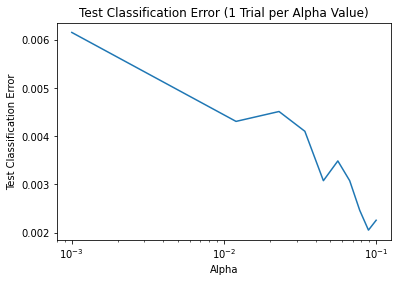

In [37]:
#Create list of values for alpha
alpha_list = np.linspace(10e-4, 1e-1, 10)
error_list = []
    
for alpha_i in alpha_list:
    clf = SGDClassifier(loss='log', max_iter=1000, 
                    tol=1e-3,
                    penalty='l1', alpha = alpha_i, 
                    learning_rate='invscaling', 
                    power_t=0.5,                
                    eta0=0.01,
                    verbose=0)
    clf.fit(X_train, y_train)
    error_list.append(classification_error(clf, X_test, y_test))
    
#plt.plot(alpha_list, error_averages)
plt.plot(alpha_list, error_list)
plt.xlabel('Alpha')
plt.ylabel('Test Classification Error')
plt.xscale('log')
plt.title('Test Classification Error (1 Trial per Alpha Value)')

Text(0.5, 1.0, 'Test Classification Error (10 Trials per Alpha Value)')

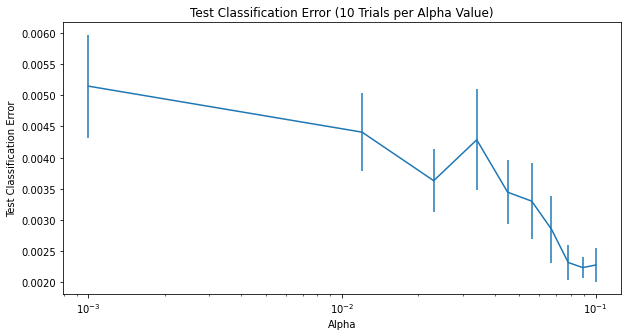

In [38]:
#Create list of values for alpha
plt.figure(figsize = (10,5))
alpha_list = np.linspace(10e-4, 1e-1, 10)
error_list = []
    
#Loop through alpha values
for alpha_i in alpha_list:
    #Repeat 10 times for each alpha
    for i in range(10):
        clf = SGDClassifier(loss='log', max_iter=1000, 
                        tol=1e-3,
                        penalty='l1', alpha = alpha_i, 
                        learning_rate='invscaling', 
                        power_t=0.5,                
                        eta0=0.01,
                        verbose=0)
        clf.fit(X_train, y_train)
        error_list.append(classification_error(clf, X_test, y_test))
        
#Reshape error list
error_list_reshaped = np.reshape(error_list, (10, 10))

#Calculate mean error and standard deviation for each alpha
error_averages = []
error_std = []
for i in range(10):
    error_averages.append(np.mean(error_list_reshaped[i]))
    error_std.append(np.std(error_list_reshaped[i]))
    
#plt.plot(alpha_list, error_averages)
plt.errorbar(alpha_list, error_averages, yerr = error_std)
plt.xlabel('Alpha')
plt.ylabel('Test Classification Error')
plt.xscale('log')
plt.title('Test Classification Error (10 Trials per Alpha Value)')

In [39]:
optimal_alpha_formatted = "{:.3f}".format(alpha_list[8])
averaged_error_formatted = "{:.5f}".format(np.min(error_averages))

print(f"Optimal value of alpha: {optimal_alpha_formatted}, resulting in average error of: {averaged_error_formatted}")

Optimal value of alpha: 0.089, resulting in average error of: 0.00223


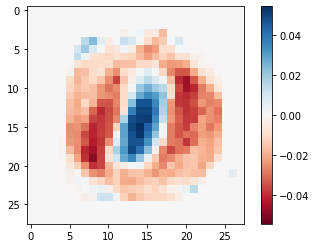

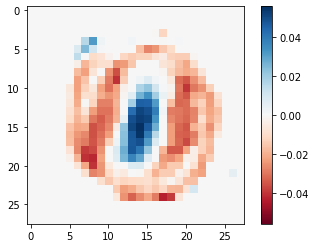

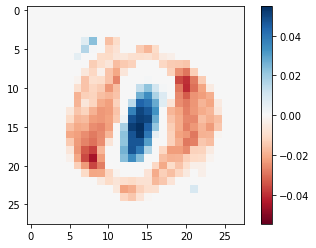

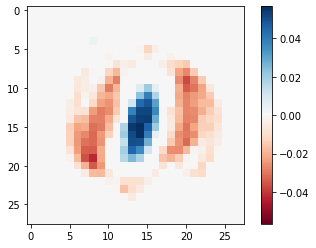

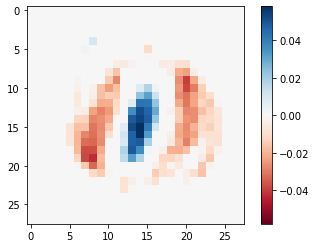

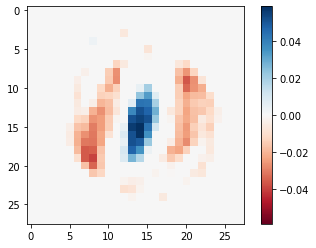

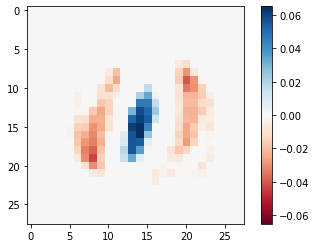

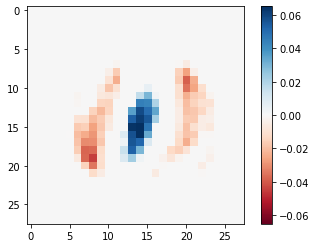

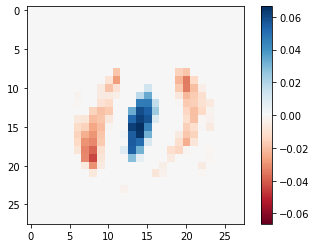

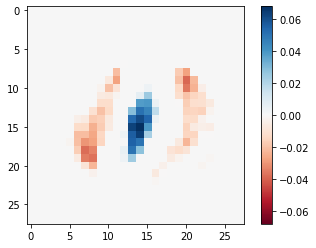

In [40]:
#Set alpha list and initialize theta list
alpha_list = np.linspace(10e-4, 1e-1, 10)
theta_list = []
    
#Loop through alpha values, update theta
for alpha_i in alpha_list:
    clf = SGDClassifier(loss='log', max_iter=1000, 
                    tol=1e-3,
                    penalty='l1', alpha = alpha_i, 
                    learning_rate='invscaling', 
                    power_t=0.5,                
                    eta0=0.01,
                    verbose=0)
    clf.fit(X_train, y_train)
    theta_i = clf.coef_
    theta_list.append(theta_i)
    
    #Plot each fitted theta
    theta_reshaped = np.reshape(theta_i, (28, 28))
    scale = np.abs(clf.coef_).max()
    plt.imshow(theta_reshaped, cmap = plt.cm.RdBu, vmax = scale, vmin = -scale)
    plt.colorbar()
    plt.show()

From the above pictures, you can observe that, as alpha increases from 10e-4 to 1e-1, there are much fewer red pixels (negative), slightly fewer blue pixels (positive), and overal more pixels that are grey (near 0). Generally, the range of our values in theta decreases for larger values of alpha. 

This means that, when the regularization parameter (alpha) is greater, the range of our parameters (theta) is smaller. 